In [1]:
# standard comments and imports
# jsut the basics
import string
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
import datetime
import boto3

In [ ]:
"""
So far this has mostly been a follow allong, which is all well and good. A nice warm up, with some fun api usage.
Now to put a little bit of spin on it.
"""

"""
Ideally, it should be a fully functioning script.
This means, proper inputs and optionals. File and Dir handling. Error handling. 
Maybe some other interesting features, while staying within the scope.
"""

In [39]:
plt.rc('figure', figsize=(40, 40))

In [3]:
# api keys

# IEX
IEX_API_KEY = ""
with open('iexcloud.key.txt', 'r') as file:
    IEX_API_KEY = file.readline()

# AWS
AWS_ACCESS_KEY = ''
AWS_SECRET_KEY = ''
with open('aws.rootkey.key.csv', 'r') as file:
    AWS_ACCESS_KEY  =  file.readline()[15:-1]
    AWS_SECRET_KEY = file.readline()[13:]

session = boto3.Session(
aws_access_key_id=AWS_ACCESS_KEY,
aws_secret_access_key=AWS_SECRET_KEY
)


In [30]:

# EDIT HERE

tickers = [
            'STX',
            'ZM',
            'NVDA',
            'AMD',
            'INTC',
            'WDC'
             ]
tickers_names = [
            'Lg Electronics Inc (LGLD.LN)',
            'Zoom Video Communicaions (ZM)',
            'Nvidia Corp (NVDA)',
            'Adv Micro Device (AMD)',
            'Intel Corp (INTC)',
            'Seagate Tech Ord Shs (STX)']

# MATCHING CONSTANTS

COMPANY_TYPES = 'Tech Company'
grouping = 'tech'

LOOKBACK_LENGTH = '1 month'
years = '1m'




In [31]:
# EDIT HERE
#!mkdir grouping_data_imgs

In [32]:
tickers_string = ''
for x in tickers:
    tickers_string += x+","
tickers_string = tickers_string[:-1]

# """AGREGATE DESIRED TICKERS"""
tickers_string

'STX,ZM,NVDA,AMD,INTC,WDC'

In [33]:
# creating endpoints
endpoints = 'chart'
# limited by paywall

# form http request
HTTP_req = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={tickers_string}&types={endpoints}&range={years}&token={IEX_API_KEY}'

In [35]:
data = pd.read_json(HTTP_req)

In [36]:
series_dict = {}

for ticker in tickers:
    series_dict.update({ticker : pd.DataFrame(data[ticker]['chart'])['close']})
    
series_list = [pd.DataFrame(data[ticker]['chart'])['close'] for ticker in tickers]

series_list.append(pd.DataFrame(data[ticker]['chart'])['date'])
                            
col_names = tickers.copy()
col_names.append('Date')
        
data_concat = data.copy()
data_concat = pd.concat(series_list, axis=1)
    
data_concat.columns = col_names

data_concat
data_concat.set_index('Date', inplace = True)

In [37]:
%matplotlib inline

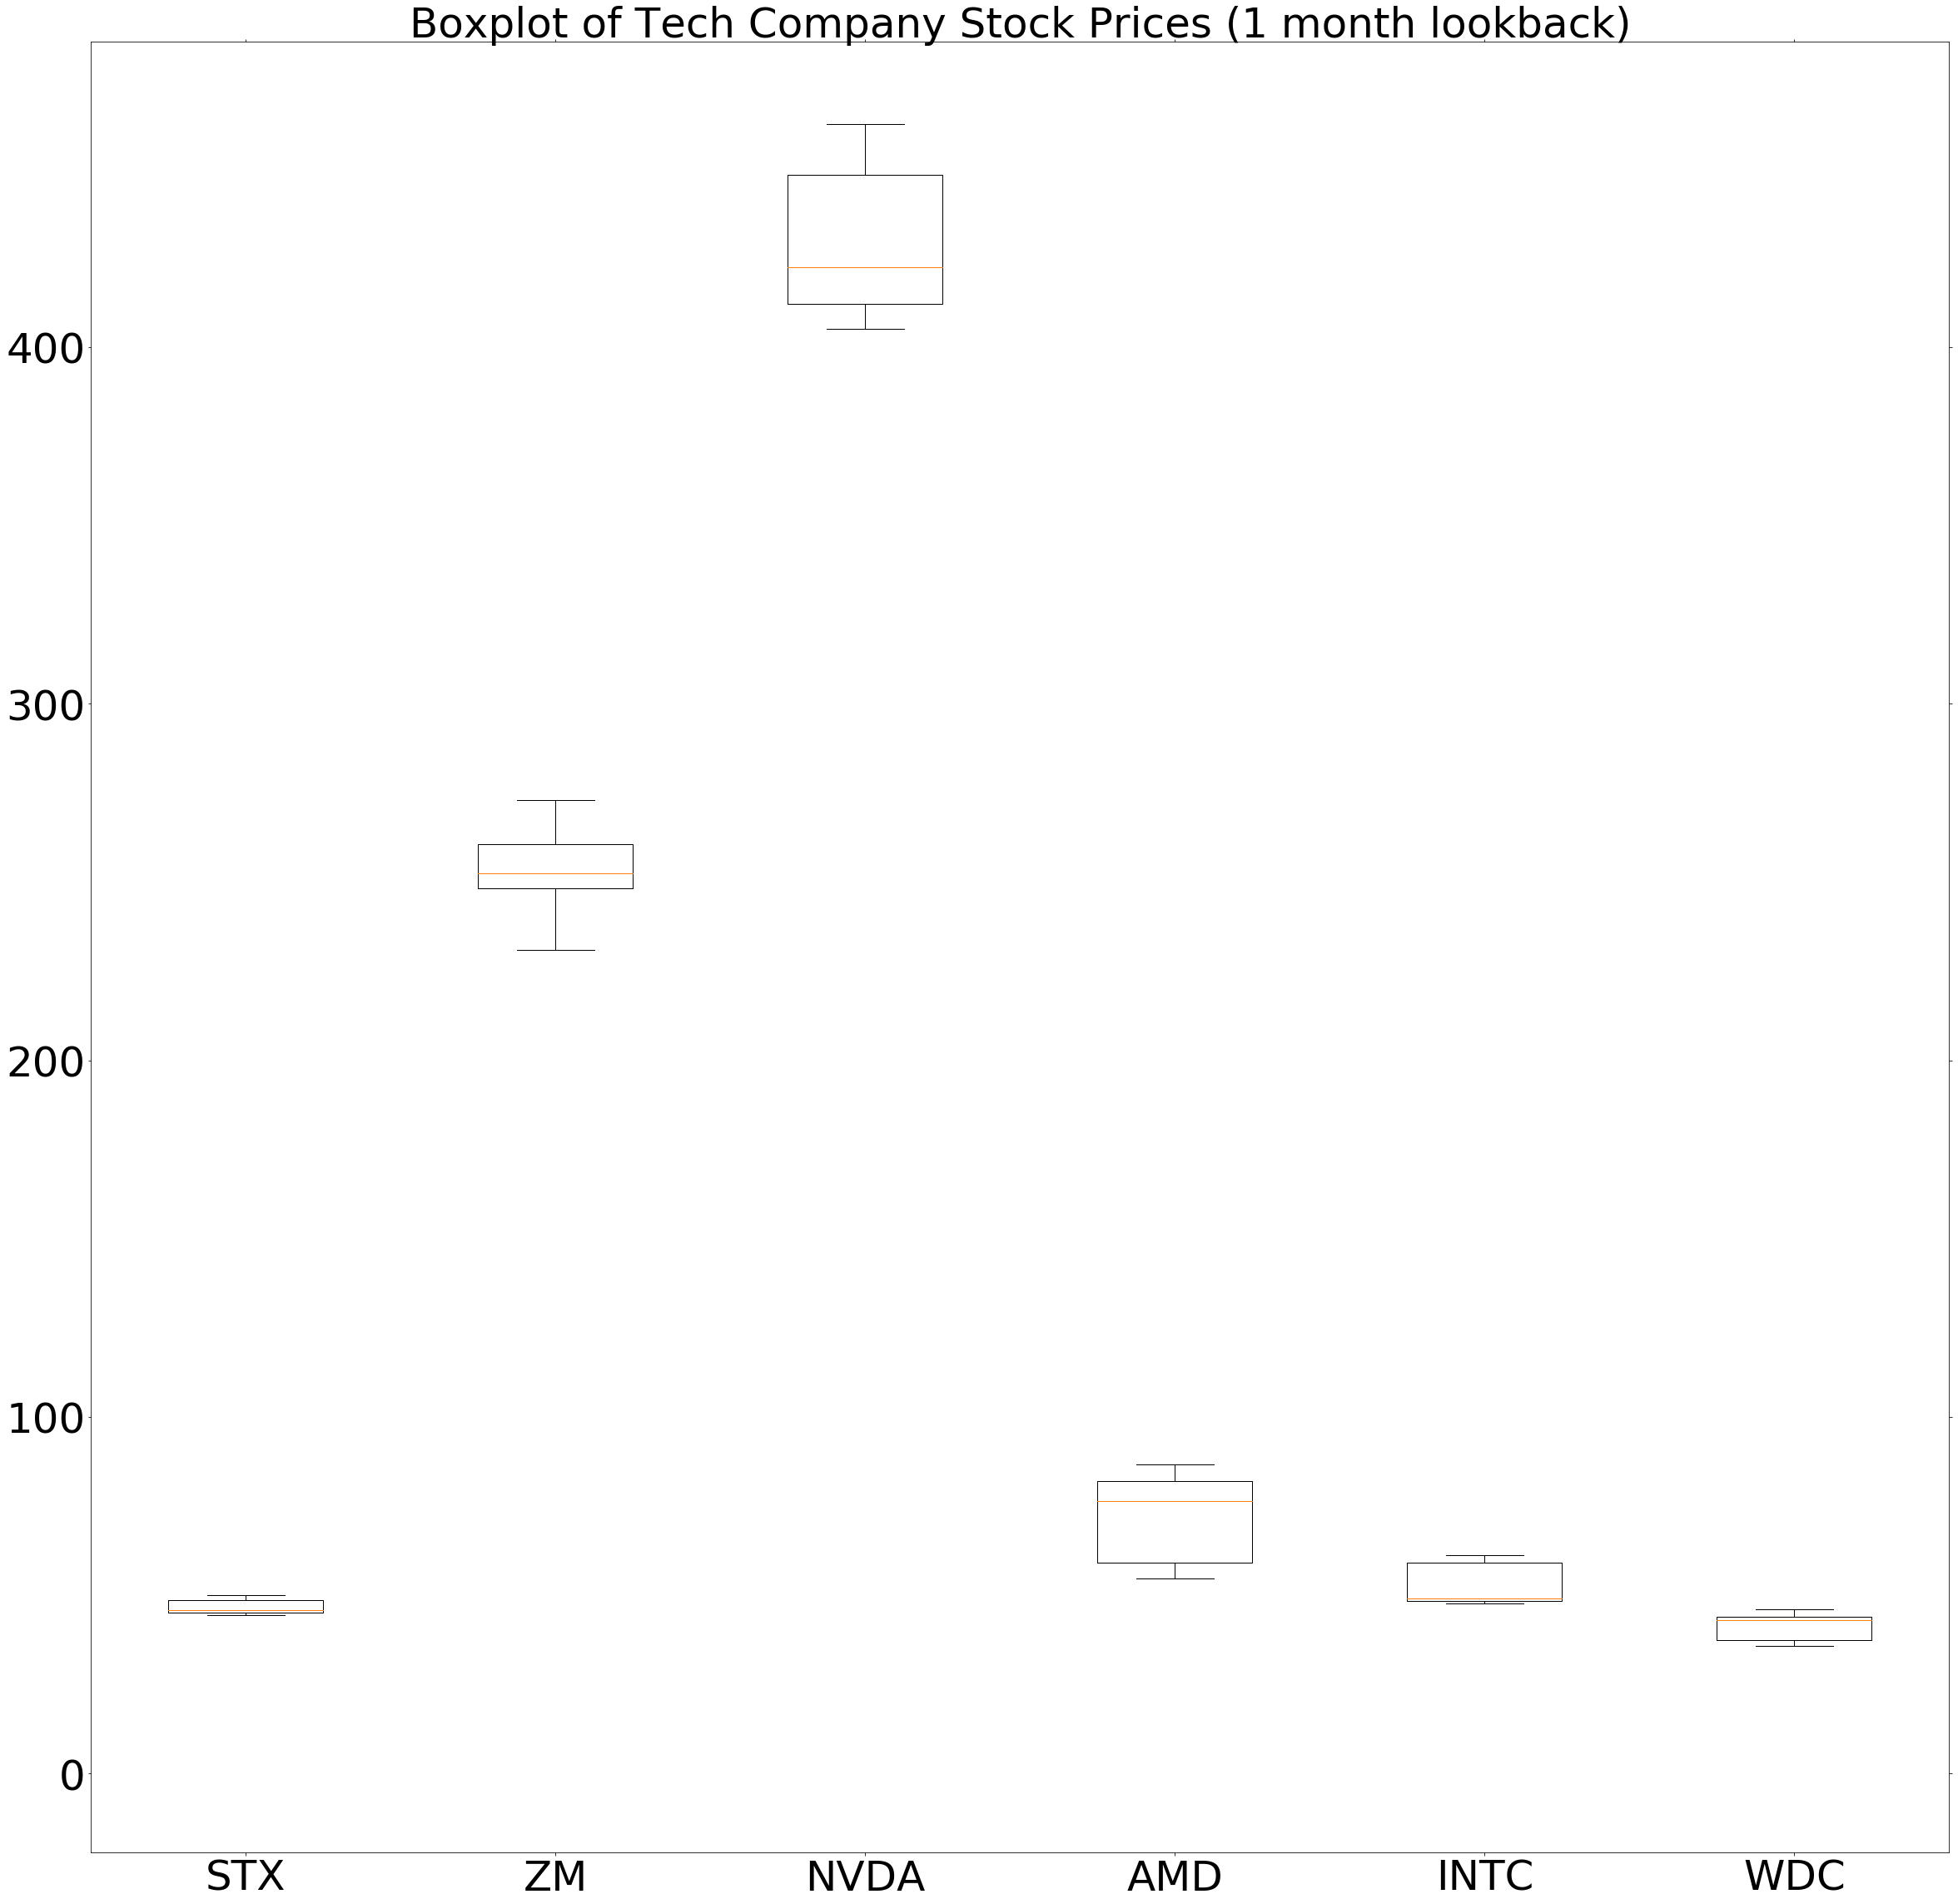

In [40]:
fig = plt.figure()


ax = fig.add_subplot(111)

ax.boxplot(data_concat.T)

plt.title(f'Boxplot of {COMPANY_TYPES} Stock Prices ({LOOKBACK_LENGTH} lookback)', fontsize = 50)

ticks = range(1, len(data.columns)+1)
labels = list(data.columns)




plt.xticks(ticks,labels, fontsize = 50)
plt.yticks(fontsize = 50)





ax.plot([1],[1])
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')

today = datetime.datetime.now()

fig.savefig(f'{grouping}_data_imgs/boxplot-{str(today.date())}.png')

In [41]:
dates_full = data_concat.index.to_series()
dates_full = [str(pd.to_datetime(d)) for d in dates_full]



In [42]:
if 'y' in years:
    dates = [ x[5:-9]+'-'+x[2:4] for x in dates_full]
    range_points = []
    month = ''
    for i,d in enumerate(dates):
        if month == '':
            month = d[0:2]
            range_points.append(i)
        if month != d[0:2]:
            month = d[0:2]
            range_points.append(i)
else:
    dates = [ x[5:-9]+'-'+x[2:4] for x in dates_full]
    range_points = [0]
    mdec = len(dates)/10
    for i,d in enumerate(dates):
        if len(d) % mdec == 0:
            range_points.append(i)

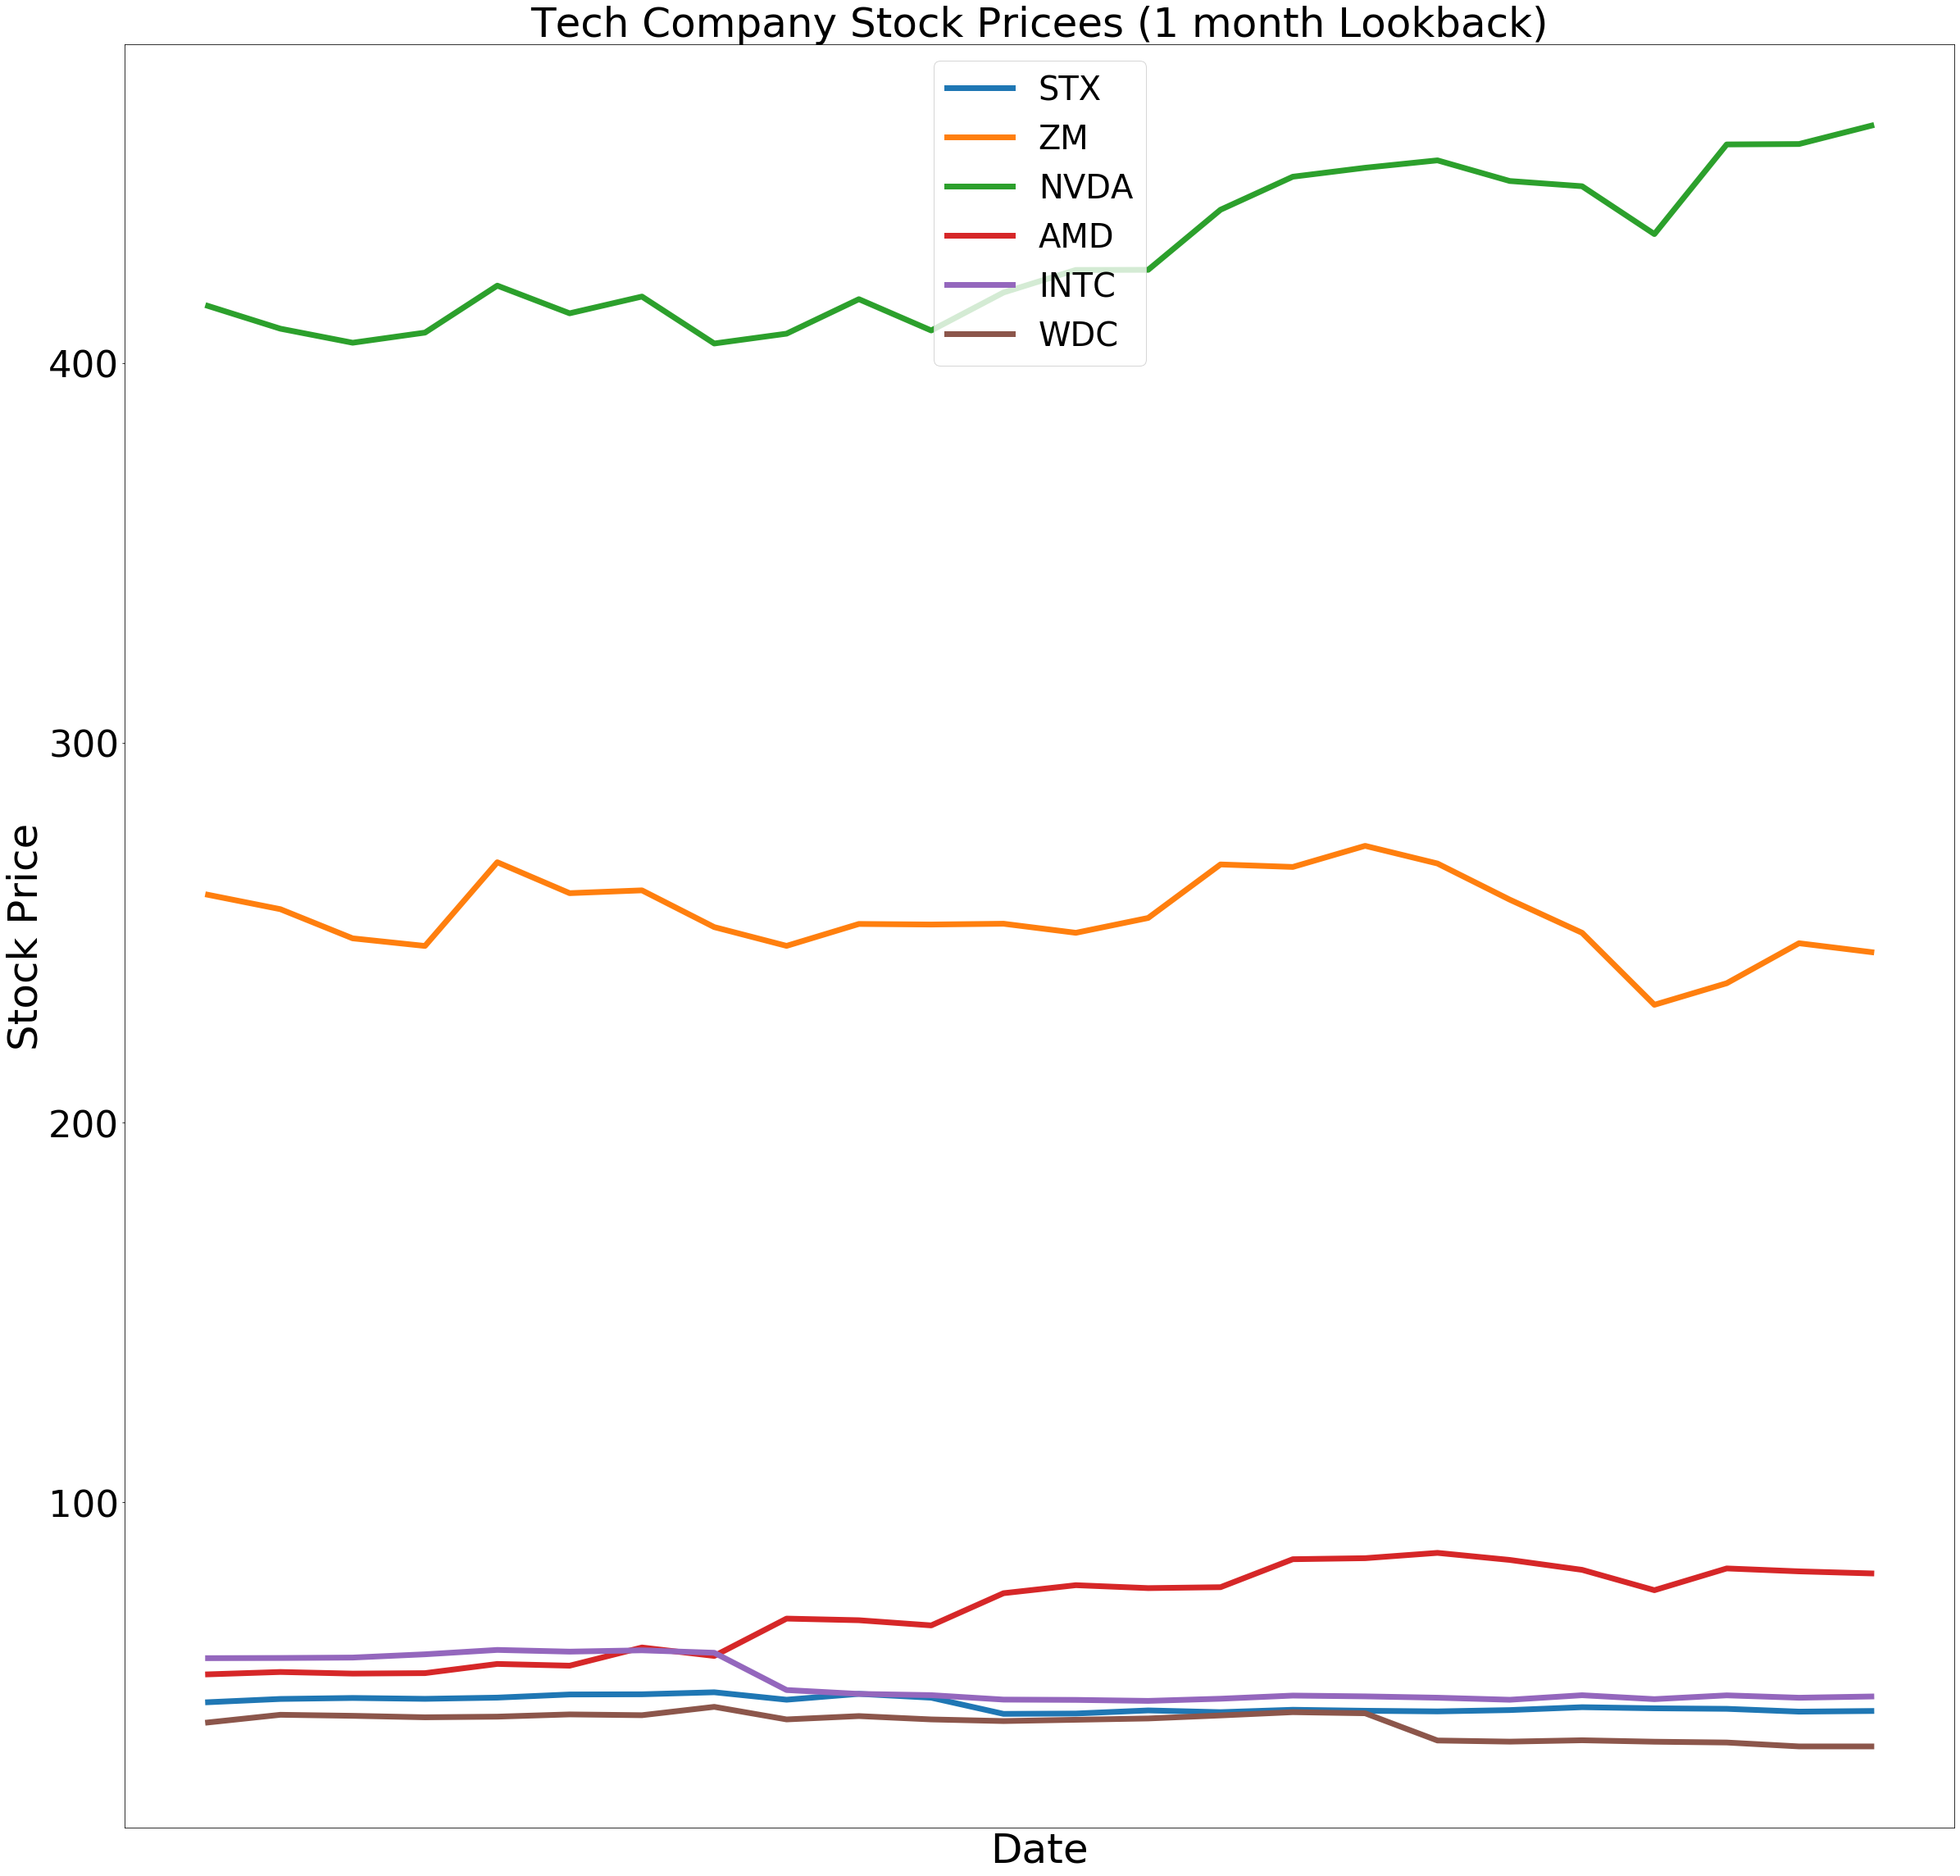

In [43]:


for ticker in tickers:
    stock_prices = data_concat[ticker]    

    #Add titles to the chart and axes
    plt.title(f'{COMPANY_TYPES} Stock Pricees ({LOOKBACK_LENGTH} Lookback)', fontsize=50)
    plt.ylabel("Stock Price", fontsize=50)
    plt.xlabel("Date", fontsize=50)
    plt.xticks(range_points[1:], fontsize = 35)
    plt.yticks(fontsize=45)
   

    #Generate the scatterplot
    plt.plot(dates, stock_prices, linewidth=7.0) 
  
    
    plt.legend(tickers,fontsize = 40)
    
    
today = datetime.datetime.now()

plt.savefig(f'{grouping}_data_imgs/lineplot-{str(today.date())}.png')

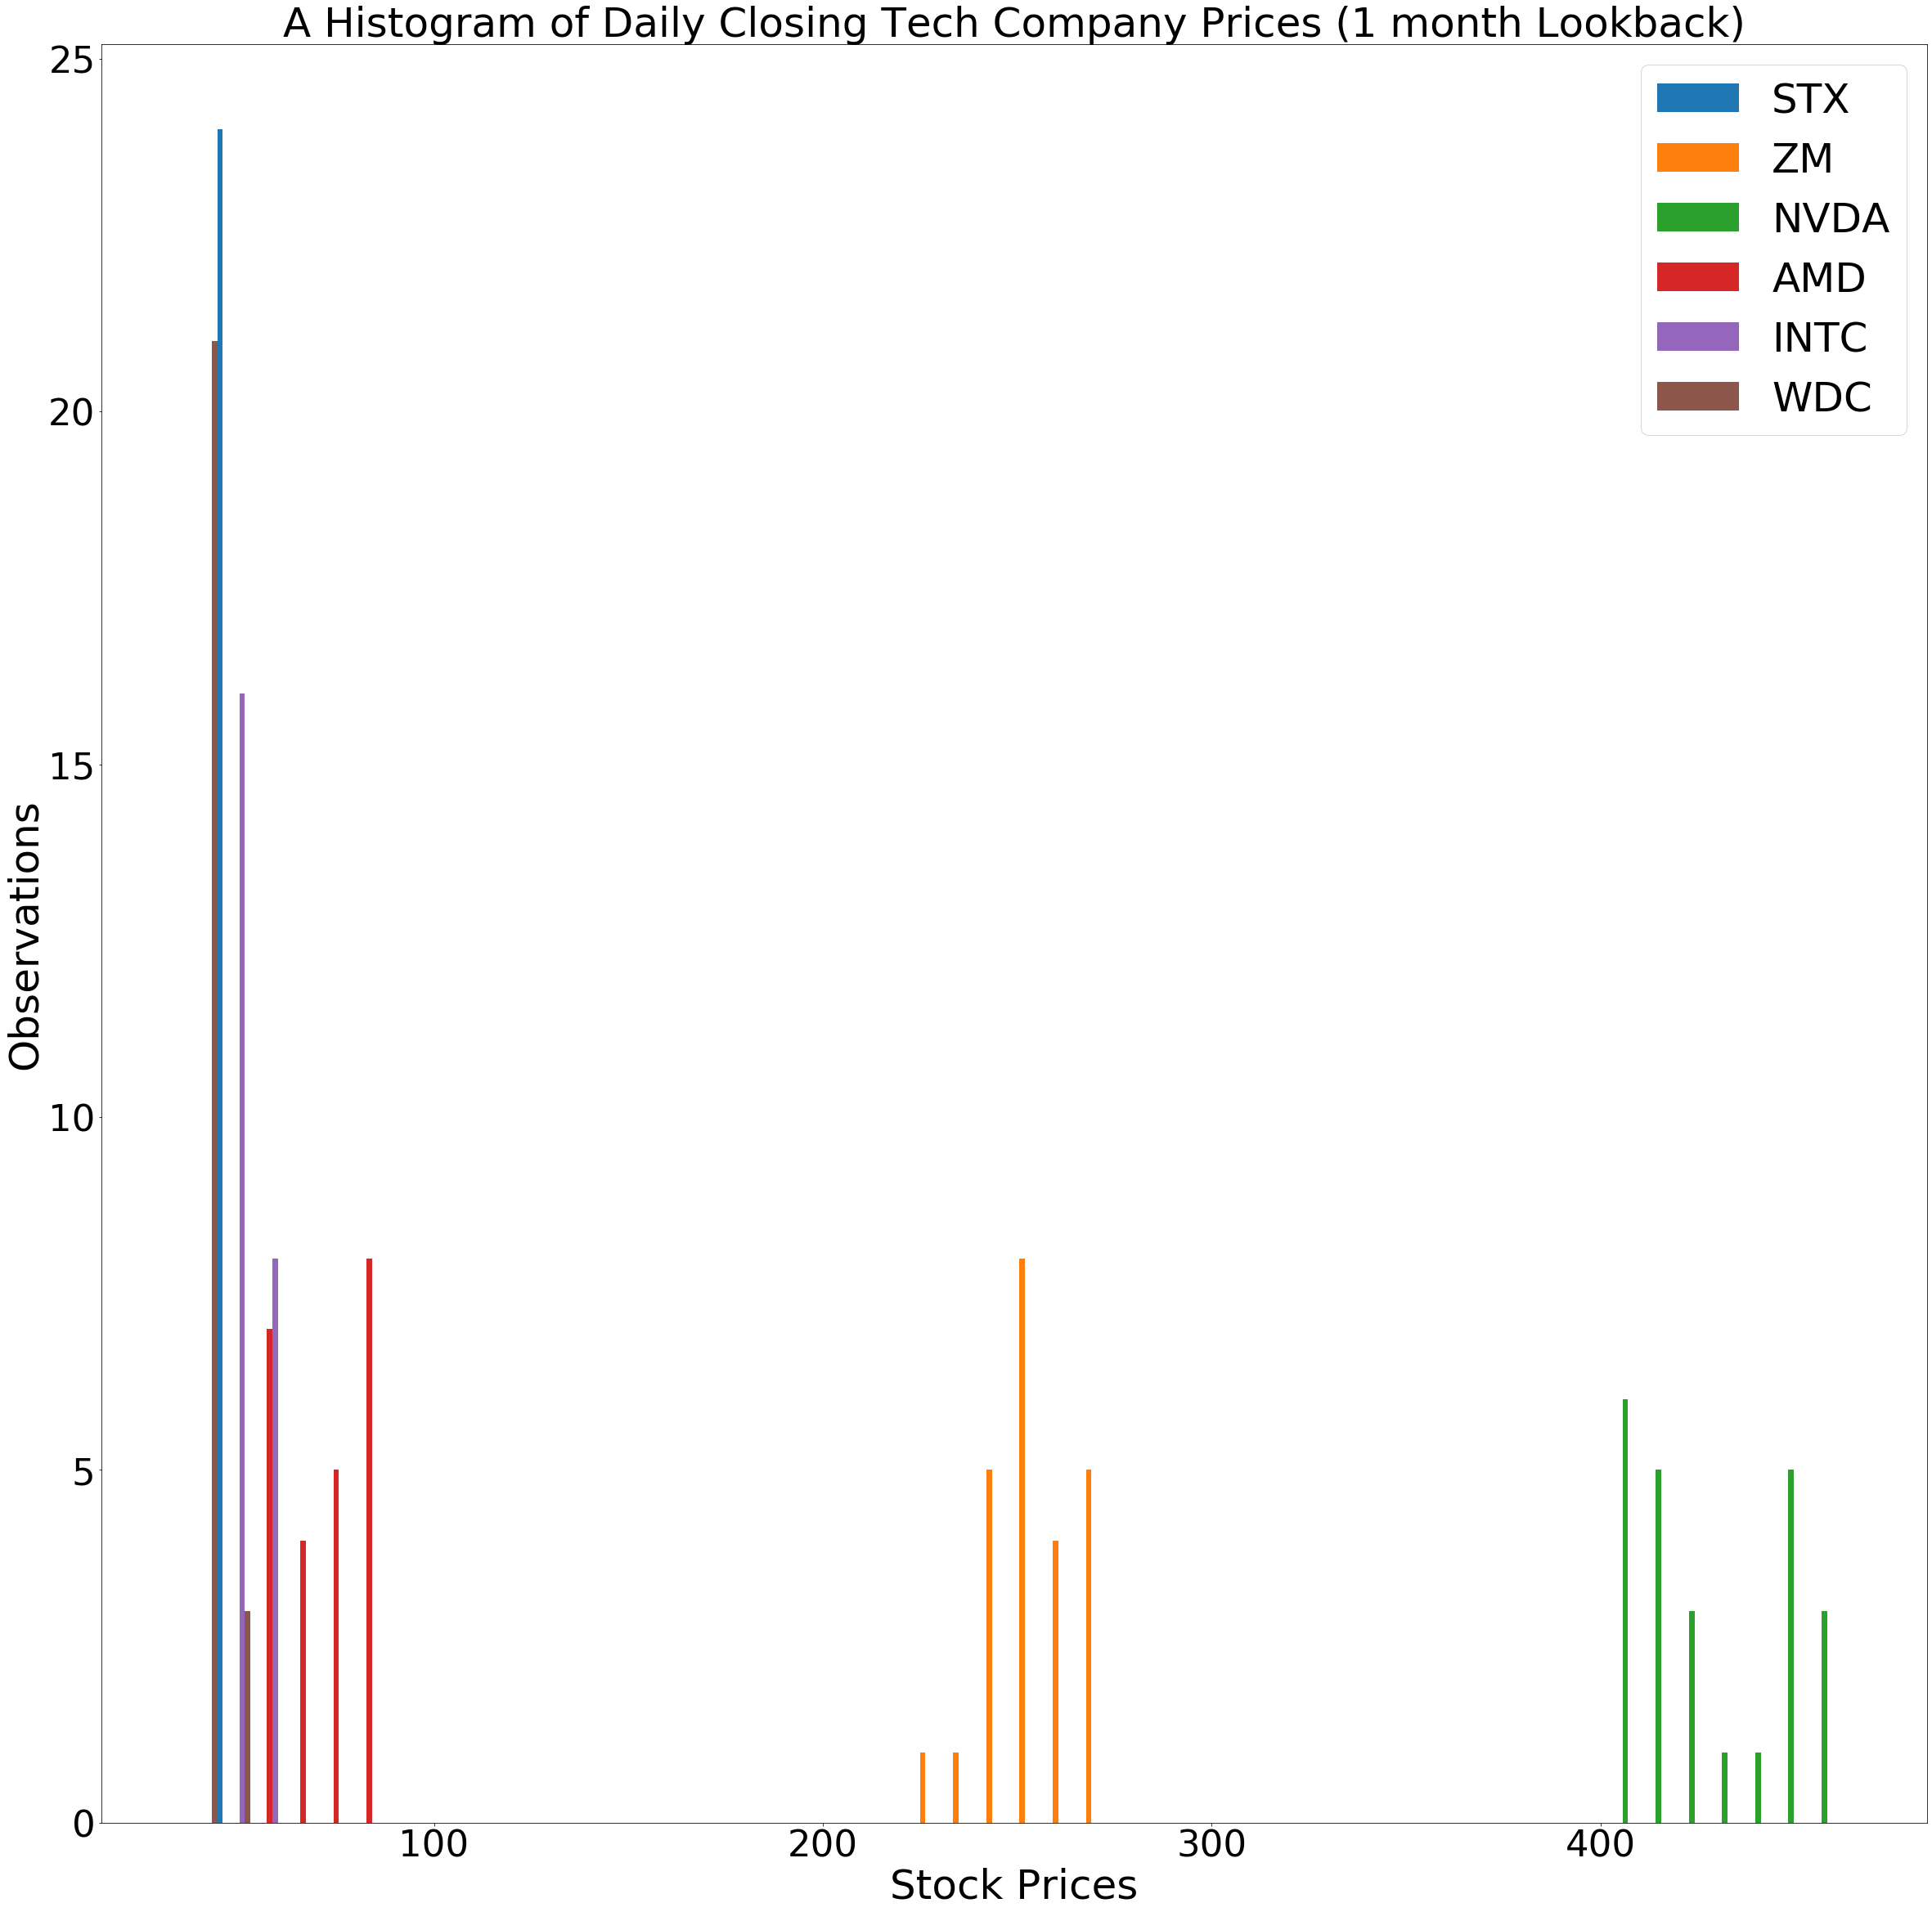

In [44]:
plt.hist(data_concat.transpose(), bins = 50, rwidth=1)
plt.legend(data.columns,fontsize=50)
plt.title(f'A Histogram of Daily Closing {COMPANY_TYPES} Prices ({LOOKBACK_LENGTH} Lookback)', fontsize = 50)
plt.ylabel("Observations", fontsize = 50)
plt.xlabel("Stock Prices", fontsize = 50)
plt.xticks(fontsize = 45)
plt.yticks(fontsize=45)


today = datetime.datetime.now()

plt.savefig(f'{grouping}_data_imgs/histogram-{str(today.date())}.png')

In [45]:
s3 = session.resource('s3')
s3.meta.client.upload_file(f'{grouping}_data_imgs/boxplot-{str(today.date())}.png', 
                           'daniel-one-bucket', 
                           f'{grouping}_data_imgs/boxplot-{str(today.date())}.png', 
                           ExtraArgs={'ACL':'public-read'})
s3.meta.client.upload_file(f'{grouping}_data_imgs/lineplot-{str(today.date())}.png', 
                           'daniel-one-bucket', 
                           f'{grouping}_data_imgs/lineplot-{str(today.date())}.png', 
                           ExtraArgs={'ACL':'public-read'})
s3.meta.client.upload_file(f'{grouping}_data_imgs/histogram-{str(today.date())}.png', 
                           'daniel-one-bucket', 
                           f'{grouping}_data_imgs/histogram-{str(today.date())}.png', 
                           ExtraArgs={'ACL':'public-read'})